Author: Thibeau Wouters

##### Imports:

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

##### Configure matplotlib settings

In [2]:
plt.style.use('ggplot')
plt.rcParams.update(
    {"text.usetex": True,
     'font.serif': 'Modern Roman',
     "figure.figsize": (10, 8),
    "axes.titlesize" : 26,
    "axes.labelsize" : 28,
    "lines.linewidth": 2,
    "lines.markersize" : 8,
     'legend.fontsize': 17,
    "xtick.labelsize" : 24,
    "ytick.labelsize" : 24})

##### Functions:

In [3]:
def update_state(state, reaction):
    '''When the reaction is chosen, updates the state of the system accordingly.'''
    X1 = state[0]
    X2 = state[1]
    
    if reaction == 1:
        new_X1 = X1 + 1
        new_X2 = X2
        
    if reaction == 2:
        new_X1 = X1 - 1
        new_X2 = X2 + 1
        
    if reaction == 3:
        new_X1 = X1
        new_X2 = X2 - 1
    
    return (new_X1, new_X2)

In [4]:
def gillespie_step(state, t):
    '''Performs one step in the Gillespie algorithm. Updates the state of the system, as well as the time.'''
    
    X1 = state[0]
    X2 = state[1]
    
    # Compute the rates
    a1 = k1*X1
    a2 = k2*X1*X2
    a3 = k3*X2
    a0 = a1 + a2 + a3
    
    beta = 1/a0
    
    # Update the time
    tau = np.random.exponential(beta) 
    new_time = t + tau
    
    # Choose the reaction
    r = random.uniform(0, 1)
    if r <= a1/a0:
        reaction = 1
    if r > a1/a0 and r<= (a1 + a2)/a0:
        reaction = 2
    if r > (a1 + a2)/a0:
        reaction = 3
        
    # Update according to chosen reaction
    new_state = update_state(state, reaction)
    
    return (new_state, new_time)

In [5]:
def gillespie_algorithm(initial, end_time = 10**4):
    '''Performs the Gillespie algorithm starting from a certain initial state. end_time is an optional argument which 
        determines when the function call should stop, in case the system does not end in an absorbing state.'''
    # Initial conditions
    states = [initial]
    times = [0]
    
    # Check if i) extinction occurred, ii) time limit is reached...
    while times[-1] <= end_time and states[-1][0] != 0 and states[-1][1] != 0:
    
        # ... and do a Gillespie step if this is not the case
        new_state, new_time = gillespie_step(states[-1], times[-1])
        states.append(new_state)
        times.append(new_time)
    
    return (states, times)

In [6]:
def estimate_oscillations(states):
    '''Estimates how many oscillations were done in a run of the Gillespie algorithm.'''
    n_osc = 0
    
    small = False # < 70
    big = True # >= 100 so also the initial condition for our problem
    
    small_to_big = False
    big_to_small = False
    
    for i in range(len(states)):
        
        # Check when the trajectory is starting to peak
        if states[i][0] >= 100 and small == True:
            small_to_big = True
            small = False; big = True
        
        # Check when the trajectory becomes very low
        if states[i][0] < 70 and big == True:
            big_to_small = True
            small = True; big = False
        
        # If we did a peak and a 'valley', we did one oscillation: update accordingly
        if small_to_big == True and big_to_small == True:
            small_to_big = False
            big_to_small = False
            n_osc += 1
            
    return n_osc        

# 15 - Lotka-Volterra model

We start off by initialising the rates and the initial conditions given in the problem. We also compute the non-zero stationary solution, since we will often show this explicitly in our plots, since the trajectories will be oscillations around this stationary solution.

In [7]:
k1 = 1; k2 = 0.005; k3 = 0.6
initial = (100, 20)

For information, the non-zero stationary solution is given by the initial conditions:

In [8]:
stationary = (k3/k2, k1/k2)
print(stationary)

(120.0, 200.0)


# 15.1 - Compute trajectories

### 15.1.1 - Trajectories in the plane

X1 is extinct


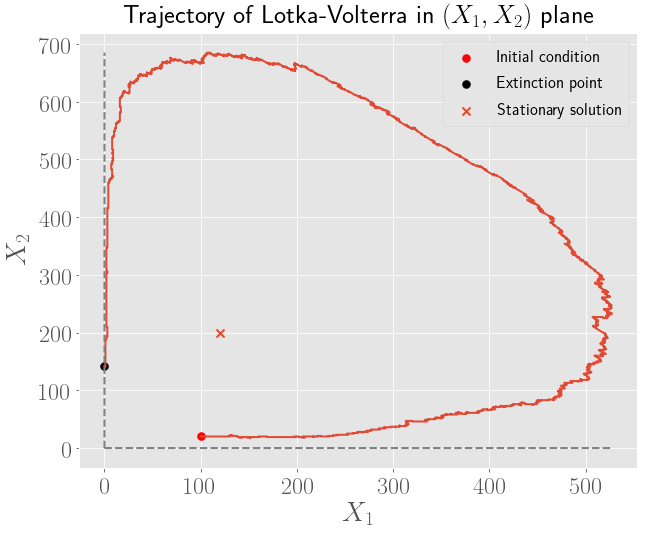

In [23]:
# Obtain the states of the system:
states, times = gillespie_algorithm(initial) 

# Before plotting: check if an extinction appeared, needed for the plot
extinct = False

if states[-1][0] == 0:
    extinct = True
    print('X1 is extinct')
if states[-1][1] == 0:
    extinct = True
    print('X2 is extinct')    

# Plot the X1, X2 trajectories:
xdata = [pos[0] for pos in states]
ydata = [pos[1] for pos in states]

# Draw points: the initial condition, the extinction point (if present), and the stationary solution
plt.scatter(initial[0], initial[1], marker = 'o', color = 'red', label = 'Initial condition')
if extinct:
    plt.scatter(xdata[-1], ydata[-1], marker = 'o', color = 'black', label = 'Extinction point')

plt.scatter(stationary[0], stationary[1], marker = "x", label = 'Stationary solution')
    
# Draw the trajectory    
plt.plot(xdata, ydata)

# Draw axes as help lines
tx = np.arange(0, np.max(xdata), 0.01)
ty = np.arange(0, np.max(ydata), 0.01)
plt.plot([0 for val in ty], ty, '--', color = 'grey')
plt.plot(tx, [0 for val in tx], '--', color = 'grey')

plt.legend()
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.title(r'Trajectory of Lotka-Volterra in $(X_1, X_2)$ plane')
## Uncomment the next line to save the plot
#plt.savefig('ex15_trajectories_plane.pdf', bbox_inches = 'tight')
plt.show()

### 15.1.2 - Trajectories as function of time

The following plot uses the data obtained in the previous code cell.

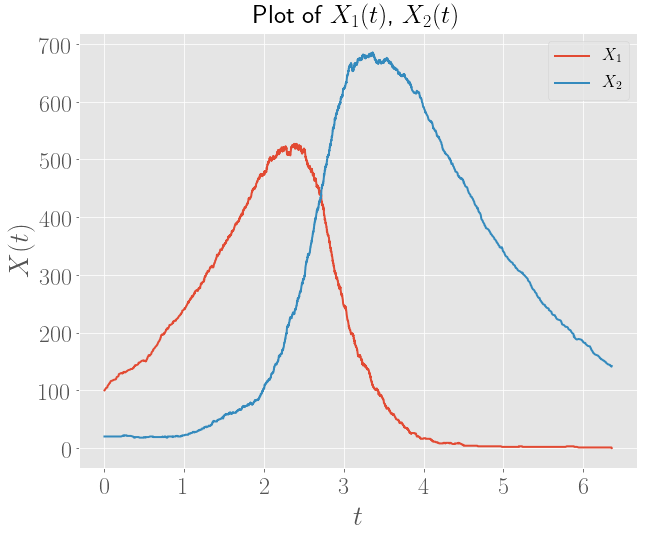

In [24]:
# Plot X1(t) and X2(t):

plt.plot(times, xdata, label = r'$X_1$')
plt.plot(times, ydata, label = r'$X_2$')

# Make fancy, save and show
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$X(t)$')
plt.title(r'Plot of $X_1(t)$, $X_2(t)$')
## Uncomment the next line to save the plot
#plt.savefig('ex15_trajectory_time.pdf', bbox_inches = 'tight')
plt.show()

## 15.2 - Absorbing states: estimate of oscillations

Test the function $\texttt{estimate_oscillations}$ by running the following code:

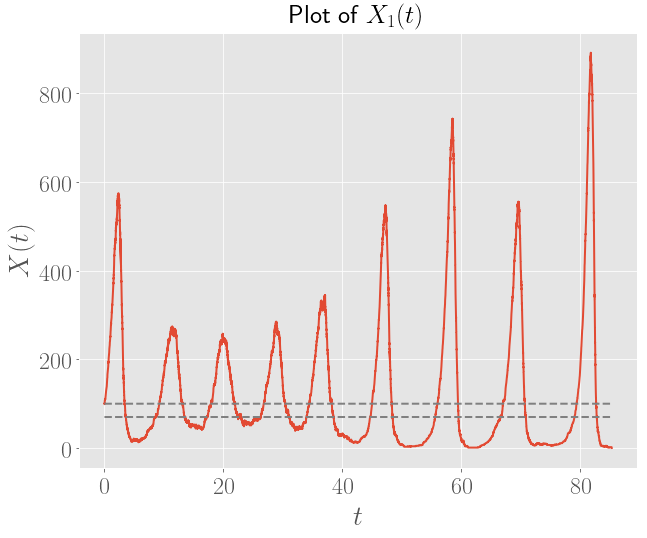

Number of oscillations is 8


In [11]:
# Obtain the states and X1 data - we can also show X2 data: uncomment those lines
states, times = gillespie_algorithm(initial) 
xdata = [pos[0] for pos in states]
#ydata = [pos[1] for pos in states]

# Plot X1(t) and help lines
plt.plot(times, xdata)
#plt.plot(times, ydata)
plt.plot(times, [100 for t in times], '--', color = 'grey') # see report: 'big'
plt.plot(times, [70 for t in times], '--', color = 'grey')  # see report: 'small'

# Make fancy, save and show
plt.xlabel(r'$t$')
plt.ylabel(r'$X(t)$')
plt.title(r'Plot of $X_1(t)$')
## Uncomment the next line to save the plot
#plt.savefig('ex15_illustration_osc_function.pdf', bbox_inches = 'tight')
plt.show()

n_osc = estimate_oscillations(states)
print('Number of oscillations is %d' %n_osc)

So the function seems to yield correct results. Note: I do not count the number of peaks. Sometimes the amount of oscillations is the number of peaks in the plot above. But often, there is a peak at the end but an unfinished oscillation which corresponds to that peak. Now prepare a large setup to get the average number of oscillations.

The next command block might take some time - change $\texttt{nrep}$ if you want it to be faster.

In [12]:
n_osc_list = []; nrep = 1000

for i in range(nrep):
    states, times = gillespie_algorithm(initial) 
    n_osc = estimate_oscillations(states)
    n_osc_list.append(n_osc)

In [13]:
print('The average number of oscillations in the system after %d runs is %0.2f' % (nrep, np.mean(n_osc_list)))

The average number of oscillations in the system after 1000 runs is 2.94


Or if we want round off to the nearest integer after we ran for a large number of times:

In [14]:
print('The average number of oscillations in the system after %d runs is %0.0f' % (nrep, np.mean(n_osc_list)))

The average number of oscillations in the system after 1000 runs is 3


## 15.3 - Absorbing states: comparison between two states

How often does system end in $X_1 = X_2 = 0$ compared to $X_1 \to +\infty, X_2 = 0$?

In [15]:
# Choose how often the algorithm should be runned
nreps = 1000

X1_extinct = 0
X2_extinct = 0

time_limit = 10**4 # in case no absorbing state is reached (almost never occurrs)

for i in range(nreps):
    states, times = gillespie_algorithm(initial, time_limit)
    if states[-1][0] == 0:
        X1_extinct += 1
    if states[-1][1] == 0:
        X2_extinct +=1

In [16]:
print('After running the algorithm a %d times, X1 went extinct in %0.2f %% of runs, X2 went extinct in %0.2f %% of runs, and in %0.2f %% of runs, no extinction happened after %d seconds.' %(nreps, 100*(X1_extinct/nreps), 100*(X2_extinct/nreps), 100*(1 - (X1_extinct + X2_extinct)/nreps), time_limit))

After running the algorithm a 1000 times, X1 went extinct in 96.00 % of runs, X2 went extinct in 4.00 % of runs, and in 0.00 % of runs, no extinction happened after 10000 seconds.


## 15.4 - Absorbing states: distribution of extinction times

Obtain extinction times of a large number of runs. This might take some time for a large number of runs!

We set a certain time limit: see the histogram below: for larger times, the cumulative histogram is approximately 1 and not much additional insight is gained if we sample larger times

In [17]:
# Choose how often the algorithm should be runned
nreps = 2000

t_limit = 200
extinction_times = []

for i in range(nreps):
    states, time = gillespie_algorithm(initial, time_limit)
    if time[-1] < t_limit:
        extinction_times.append(time[-1])

Take a look at the histogram to determine the correct distribution.

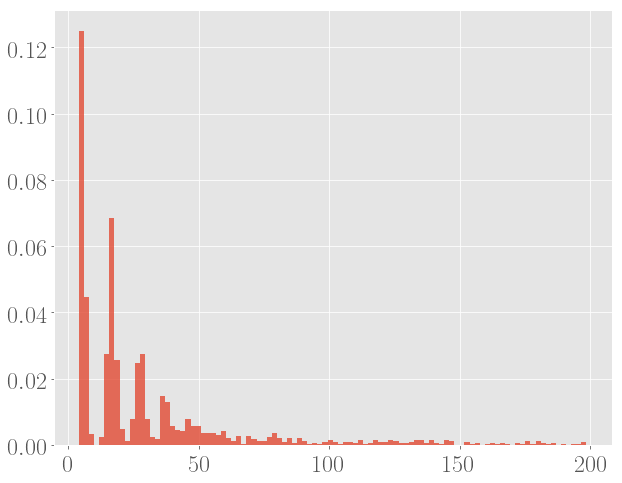

In [18]:
plt.hist(extinction_times, density = True, bins = 100, alpha = 0.8)
plt.show()

Given the histogram above is quite messy, I believe it is much better to gain insight about the possible distribution if we look at the cumulative distribution histogram.

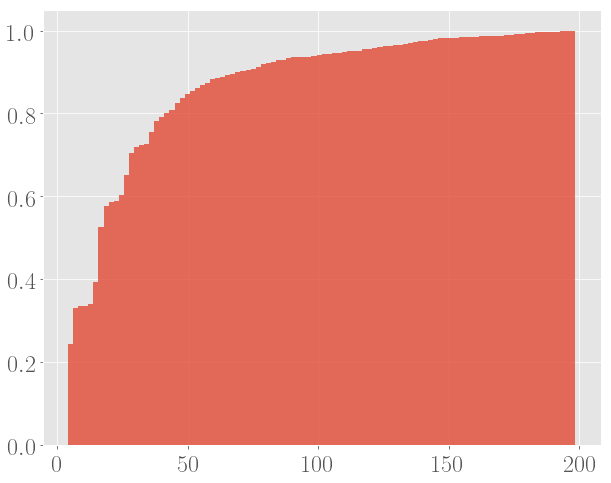

In [19]:
plt.hist(extinction_times, density = True, bins = 100, cumulative = True, alpha = 0.8)
plt.show()

Can be an exponential distribution, and to estimate the parameter $\lambda$, we take the reciprocial of the sample mean (see report).

In [20]:
L_est = 1/np.mean(extinction_times)

In [21]:
def cdf_exponential(x, L):
    return 1 - np.exp(-L*x)

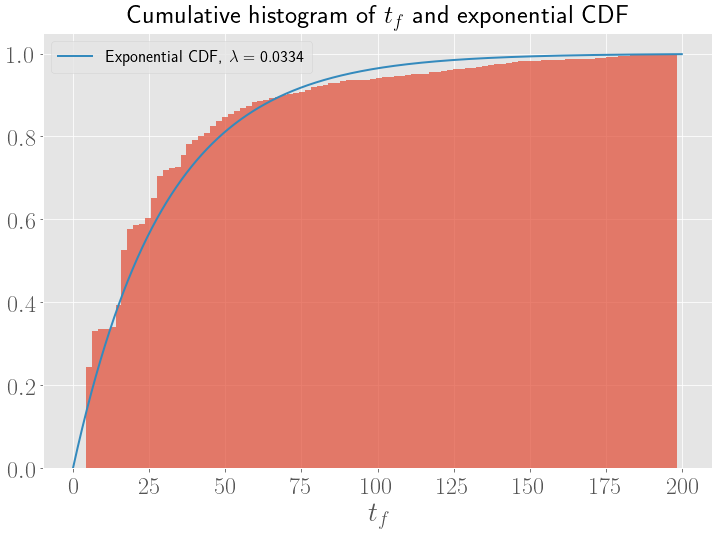

In [22]:
# Plot histogram
plt.subplots(figsize = (12, 8))
plt.hist(extinction_times, density = True, bins = 100, cumulative = True, alpha = 0.7)

# Plot CDF of exponential using estimate above
x_list = np.arange(0, t_limit, 0.1)
y = [cdf_exponential(x, L_est) for x in x_list] # exponential
plt.plot(x_list, y, label = 'Exponential CDF, $\lambda = $ %0.4f' % L_est)

# Make fancy, save and show
plt.xlabel(r'$t_f$')
plt.title('Cumulative histogram of $t_f$ and exponential CDF')
plt.legend()
## Uncomment the next line to save the plot
#plt.savefig('ex15_distr_extinction_times.pdf', bbox_inches = 'tight')
plt.show()